In [1]:
%matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
import scipy.spatial as spat
import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Using matplotlib backend: Qt5Agg


Import the usual suspects

In [2]:
PITCH = 9
alpha = 10
beta_0 = 1.3182817e+7
coupling = 191

## Building and solving a coupling matrix

We want to solve something of the form 

$i \frac{\partial \phi_n}{\partial z} = C_{m, m+a_1} e^{iA((m + a_1) /2)\cdot a_1} \phi_{m+a_1} +  C_{m, m+a_2} e^{iA((m + a_2) /2)\cdot a_2} \phi_{m+a_2}+  C_{m, m+a_3} e^{iA((m + a_3) /2)\cdot a_3} \phi_{m+a_3} + D_n \phi_n $

The first three terms are the effects due to coupling with neighbours, while the fourth term is the on-site change due to the presence of twist.

First let's define a function that handles the effects of twist

Turning to: Ma X et al. 2011 Angular-momentum coupled optical waves in chirally-coupled-core fibers Opt. Expr. 19

They find: $ \beta_{hel} \approx \beta_{straight} \sqrt{1+\alpha^2 R^2}$ 
if $(\alpha R)^2$ is small we can approximate: $\beta_{hel} \approx \beta_{straight} + \frac{\beta_{straight}}{2}(\alpha R)^2$


In [3]:
def twisted_beta(beta_straight, twist_rate, radial_dist):
    beta_hel = beta_straight*np.sqrt(1+ twist_rate**2 * radial_dist**2)
    return beta_hel

vec_twist_beta = np.vectorize(twisted_beta)

In [4]:
def build_honeycomb(n,m):
    a_1 = np.array([3*PITCH/2, np.sqrt(3)*PITCH/2])
    a_2 = np.array([3*PITCH/2, -np.sqrt(3)*PITCH/2])

    coord_list = []
    for j in range(m):
        for i in range(n): 
            coord_list.append(a_1*i + a_2*j)

    coord_list_shifted = coord_list + np.array([-PITCH, 0])
    coord_list = np.array(coord_list)
    # print(coord_list_shifted)


    full_coord_list = np.concatenate((coord_list, coord_list_shifted), axis=0)
    centered_coord_list = full_coord_list - (n*a_1 + m*a_2)/2 + np.array([2*PITCH,0])

    return centered_coord_list
b_10_list = build_honeycomb(10,10)
# plt.scatter(b_10_list[:,0], b_10_list[:,1]);   
# plt.scatter(b_10_list[:,0]-11.5*PITCH, b_10_list[:,1]-np.sqrt(3)*PITCH/2); 

plt.axhline(0, color='black')
plt.axvline(0, color='black')



plt.scatter(b_10_list[:,0], b_10_list[:,1]); 
# plt.scatter(b_10_list[:10,0], b_10_list[:10,1]);
# plt.scatter(b_10_list[10,0], b_10_list[10,1]);
# plt.scatter(b_10_list[20,0], b_10_list[20,1]);
print(len(b_10_list))

200


If we want a deformed lattice we can delete cores using the code below 

In [5]:
def onclick(event):
    pos.append([event.xdata,event.ydata])

pos = []

fig1 = plt.figure(figsize=(9,6))
ax1 = fig1.add_subplot(111)

ax1.scatter(b_10_list[:,0], b_10_list[:,1], cmap='Reds')
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
#ax1.xaxis.set_major_formatter({x:.0f})
plt.grid(which='both')

fig1.canvas.mpl_connect('button_press_event', onclick)
plt.show()


In [6]:

pos = np.array(pos)
points_to_keep = np.where(cdist(b_10_list, pos, 'euclidean')>2, False, True )
index_to_keep = np.invert(np.any(points_to_keep, axis=1))
deformed_lattice= b_10_list[index_to_keep]
# [print(type(i)) for i in pos]


In [7]:
plt.scatter(deformed_lattice[:,0], deformed_lattice[:,1]);
plt.axes().set_aspect('equal')

<ipython-input-7-817057a72463>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


Now we want to read in a geometry from COMSOL and find the nearest neighbours

In [8]:

# coord_data = pd.read_csv('../COMSOL/Data/Honeycomb/honeycomb coord locs small.csv', header=4,float_precision='round_trip')
# # coord_data = pd.read_csv('../COMSOL/Data/Honeycomb/coupled_core_locs.csv', header=4,float_precision='round_trip')

# #display(coord_data.iloc[:,1:])
# x_coords = coord_data.iloc[:,1:128]
# y_coords = coord_data.iloc[:,128:]
# x_coord_np = x_coords.transpose()[0].to_numpy()
# y_coord_np = y_coords.transpose()[0].to_numpy()

# combined_list  = np.transpose(np.array((x_coord_np,y_coord_np)))


def build_onsite(beta_straight, twist, coord_pairs):
    distance_to_each_core = np.array([round(np.sqrt(i**2 + j**2),4) for i,j in coord_pairs])*1e-6

    twist_for_each_core = vec_twist_beta(beta_straight, twist, distance_to_each_core) - beta_straight
    onsite_matrix = np.diag(twist_for_each_core)

    return onsite_matrix

Next we build up the vector potential $\mathbf{A}(\mathbf{r})$

In [9]:
def vec_potential(x,y, twist_rate, beta):
    vec_A = twist_rate*beta*np.array([y,-x])
    return vec_A


Finally we stick all of these components into our coupling matrix C

In [10]:
def find_eigvalues(pair_list, pitch, coupling_c, beta_straight, twist, with_onsite=True):
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=complex)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=100)
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.001, output_type = 'ndarray')

    for i in nearest_neighbour_array:
        mid_point = (pair_list[i[0]] + pair_list[i[1]])/2
        a_dist = (pair_list[i[0]] - pair_list[i[1]])*1.0e-6
        # print(mid_point)
        vec_term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, twist, beta_straight)

        coupling_matrix[i[0],i[1]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist))

        a_dist_rev = (pair_list[i[1]] - pair_list[i[0]])*1.0e-6
        coupling_matrix[i[1],i[0]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist_rev))
    if with_onsite is True:
        onsite_matrix = build_onsite(beta_straight, twist, pair_list)
        full_C = coupling_matrix + onsite_matrix
    else: 
        full_C = coupling_matrix
    print(np.allclose(full_C, np.transpose(np.conjugate(full_C))))
    beta_super, eigvecs = np.linalg.eigh(full_C)

    return beta_super,eigvecs


In [11]:
# Plotting betas
def plot_betas(beta_vals, coupling, point_label):
    fig1  = plt.figure(figsize=(12,12))   
    ax1 = fig1.add_subplot(111)
    ax1.scatter(np.arange(len(beta_vals)), beta_vals/coupling, label=point_label);
    ax1.set_ylabel(r'$ \beta/C$')
    ax1.set_xlabel('Mode Index')
    # ax1.set_xlim(60,100)
    plt.legend();


In [12]:
# For nice plotting of eigenvectors 
def plot_coloured_chain(intensities, circ_size, circ_locations, label):
    """
    
    """
    fig_chain = plt.figure(figsize=(15,10))
    ax_chain = fig_chain.add_subplot(111)
    intensities = intensities/np.sum(intensities)
    circ_list = []
    norm = colors.Normalize(vmin=min(np.real(intensities)), vmax=max(np.real(intensities)))
    cmap = plt.cm.get_cmap('Reds')
    cmap(norm(np.real(intensities)))

    for j in range(len(intensities)):
        #print(intensities[j])
        circ_list.append(patches.Circle((circ_locations[j][0], circ_locations[j][1]), radius=circ_size//2,
                                            color=cmap(norm(np.real(intensities[j]))),ec='black')) 

#         ax_chain.annotate(str(j), (circ_locations[j][0], circ_locations[j][1]), color='black',
#                           fontsize=10, ha='center', va='center')
   
    plt.axis('off')
    # Plot all circles
    for _circ in circ_list:
        ax_chain.add_patch(_circ)
    plt.title('Mode no. {:d}'.format(label), loc='left')
    plt.axis('scaled')
    plt.show()     
    return 

In [15]:
# beta_100 = beta_super
#print(eigvecs)
# print(beta_super)
beta_vals_1, beta_vecs_1 = find_eigvalues(b_10_list, PITCH, coupling, beta_0, 10)
beta_vals_10, beta_vecs_10 = find_eigvalues(b_10_list, 4.5, 2*coupling, beta_0, 10)
beta_vals_20, beta_vecs_20 = find_eigvalues(b_10_list, 4.5, 3*coupling, beta_0, 0)
# beta_vals_30 = find_eigvalues(b_10_list, 3.0, coupling, beta_0, 10)
# beta_vals_40 = find_eigvalues(b_10_list, 2.5, coupling, beta_0, 10)

True
True
True


We now have $i \frac{\partial \mathbf{a}}{\partial z} = C \mathbf{a}$ 
where $\mathbf{a}$ is a vector of complex amplitudes describing the contribution of each single core mode to each supermode

$\beta \mathbf{a} = C \mathbf{a}$

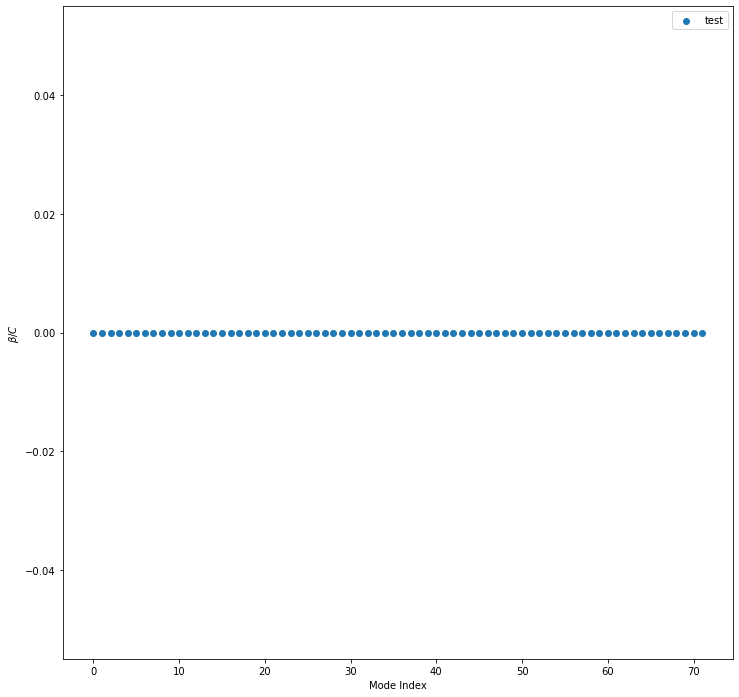

In [50]:
%matplotlib inline
plot_betas(beta_vals_20, coupling*3,'test')


Now let's look at some of the eigenmodes 

No on-site term with low twist

In [20]:
vec_intensities = np.conjugate(beta_vecs_20)*beta_vecs_20
for i in range(len(beta_vecs_20)):
    plot_coloured_chain(vec_intensities[:,i], 3, b_10_list,i)




<ipython-input-13-2292a5afa7ee>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_chain = plt.figure(figsize=(15,10))


Upping twist 
Edges present at 100, edges have moved but still present at 1000 as landau levels split further, edges still present at 10000 twist with landau levels almost washed out

True


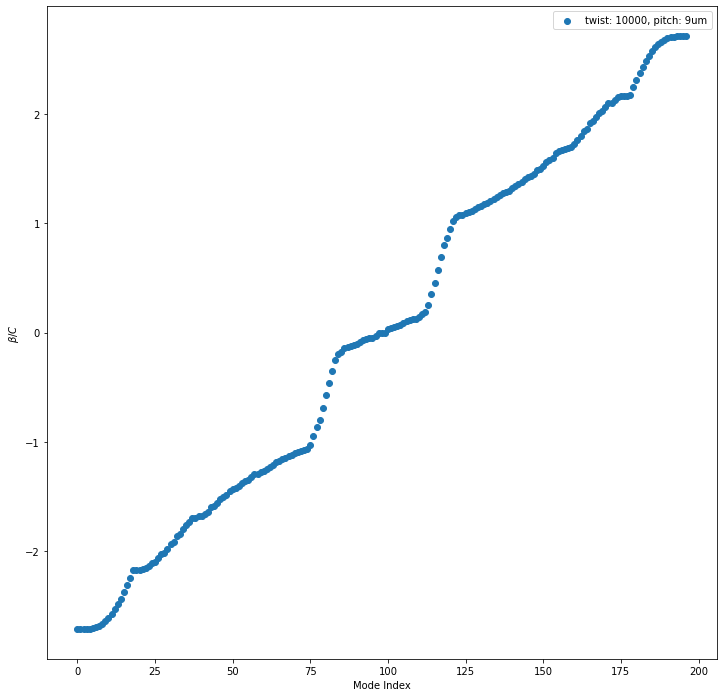

In [18]:
%matplotlib inline
beta_vals_100, beta_vecs_100 = find_eigvalues(deformed_lattice, PITCH, coupling, beta_0, 10000, with_onsite=False)
plot_betas(beta_vals_100, coupling, 'twist: 10000, pitch: 9um')

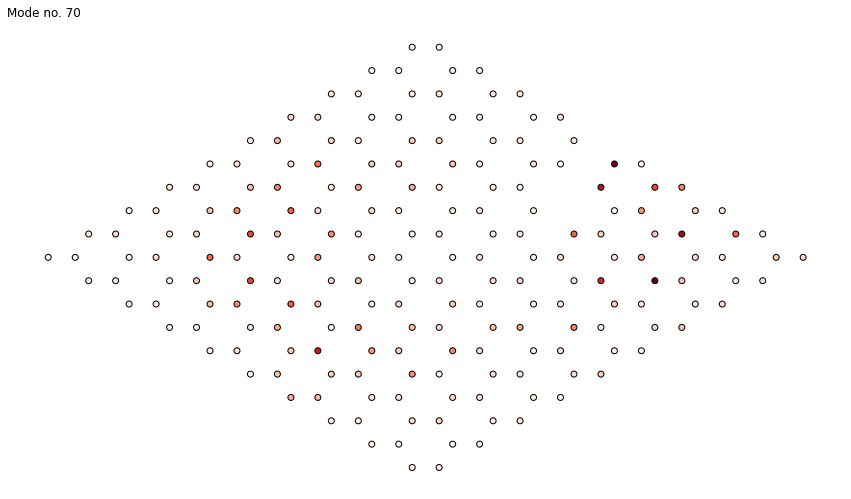

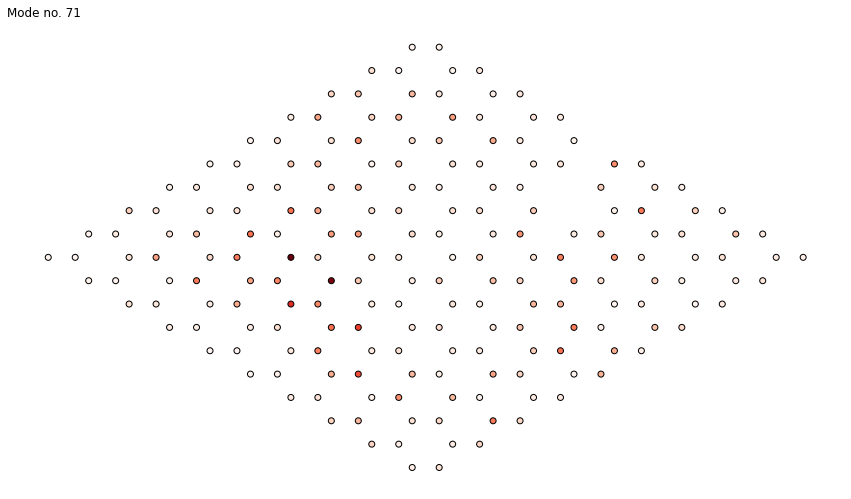

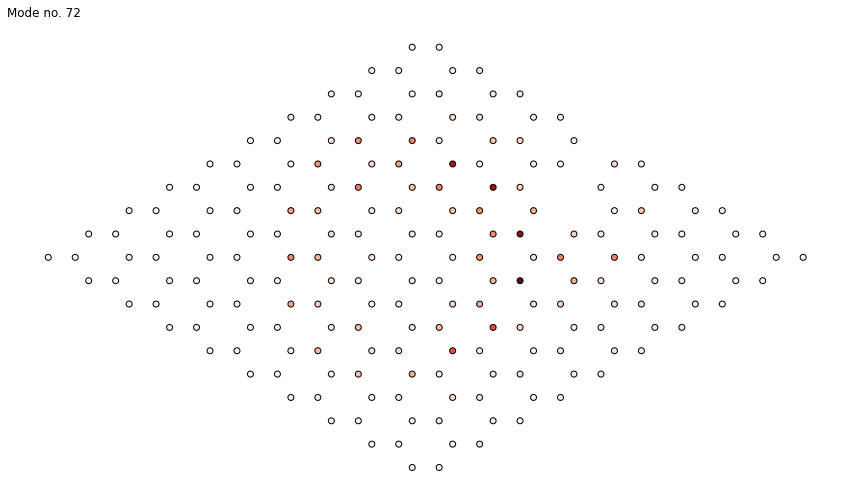

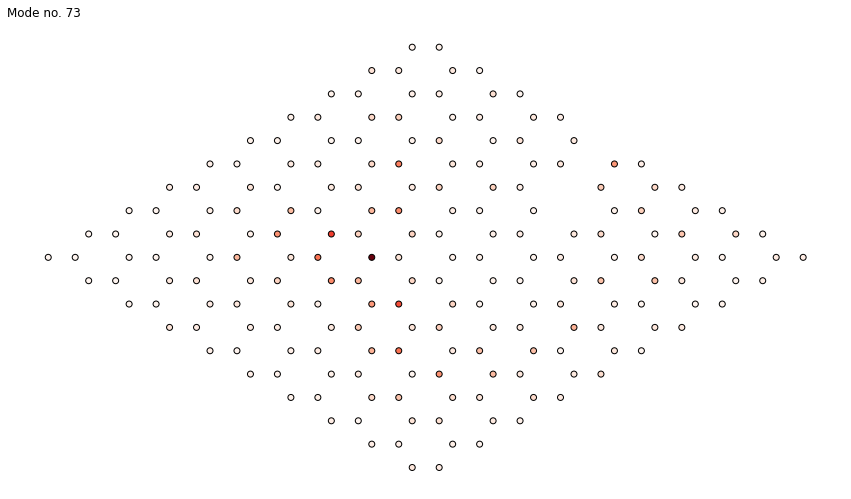

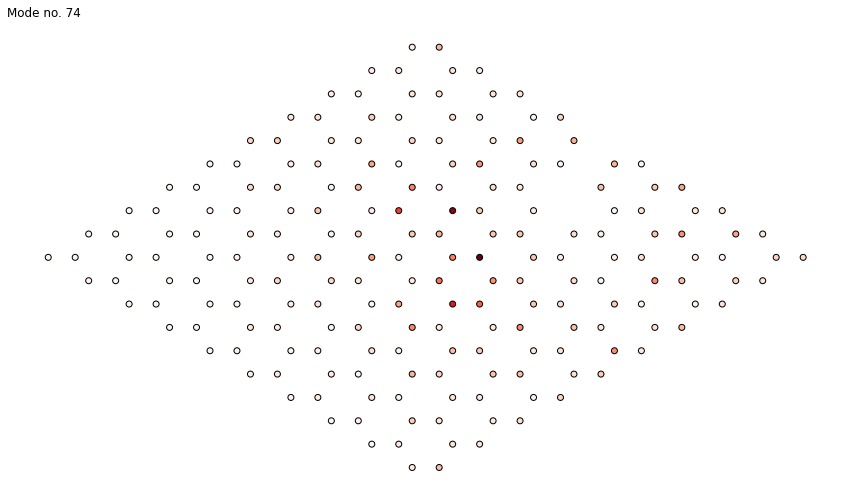

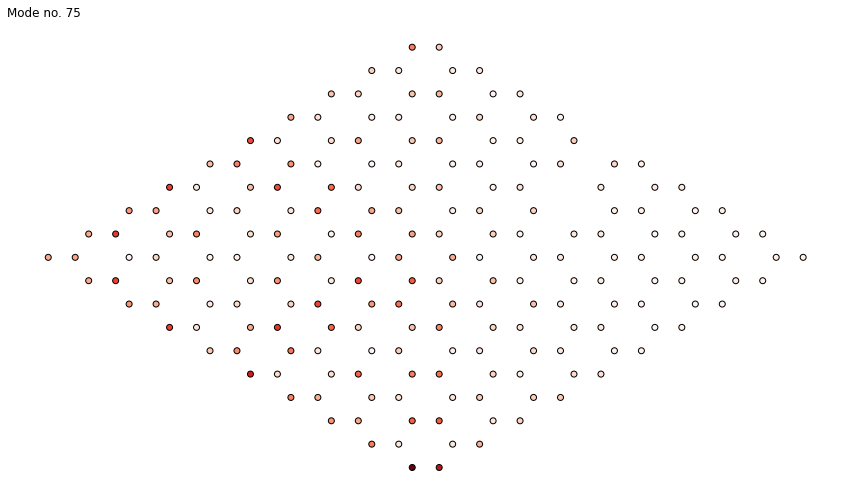

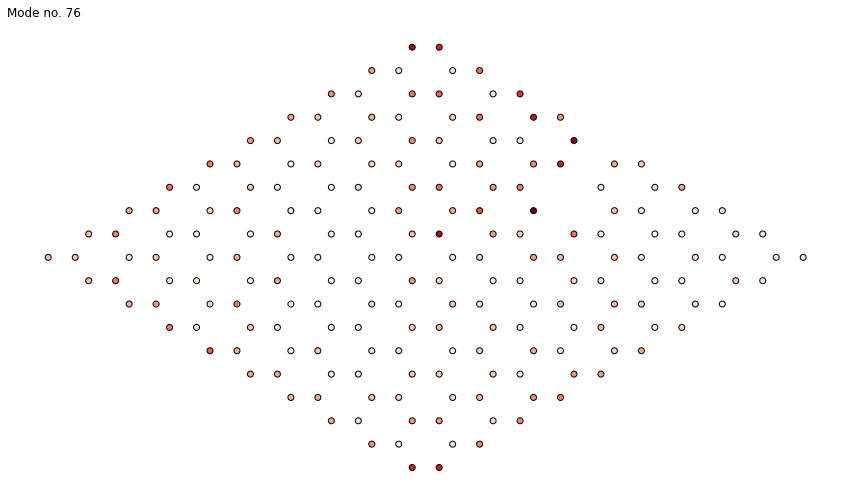

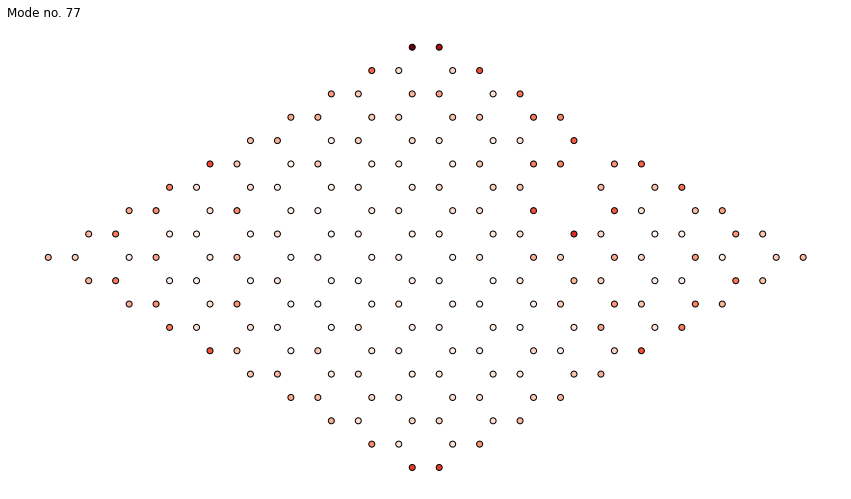

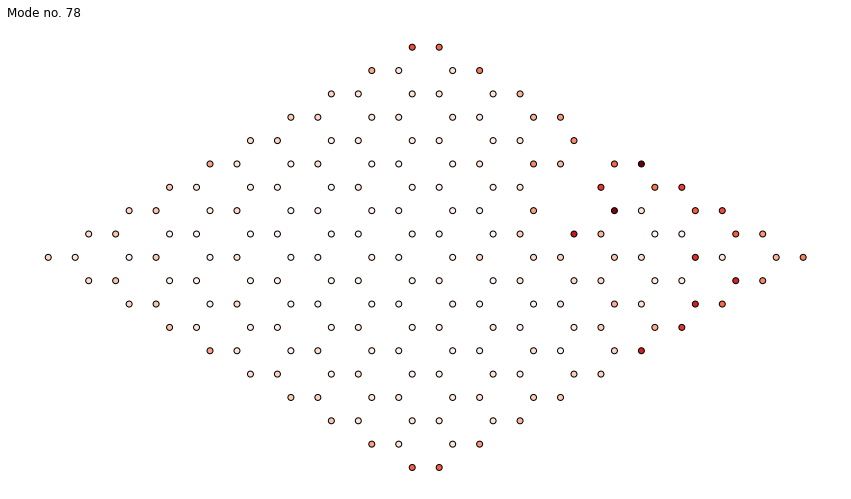

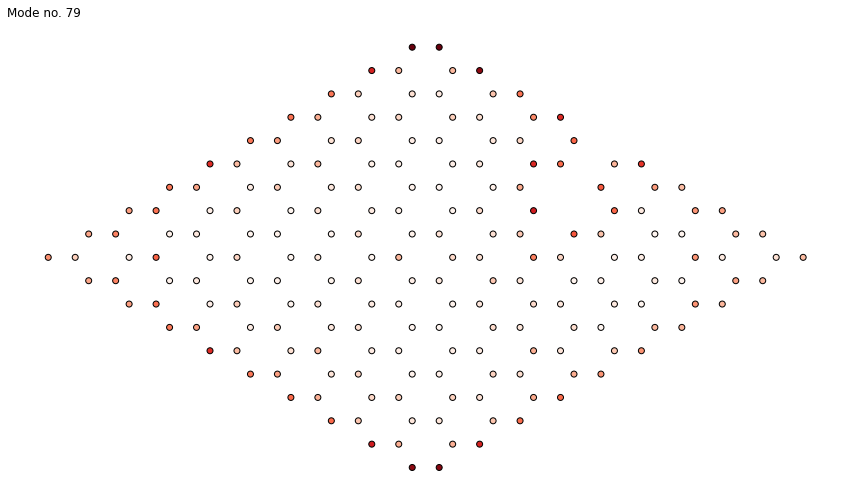

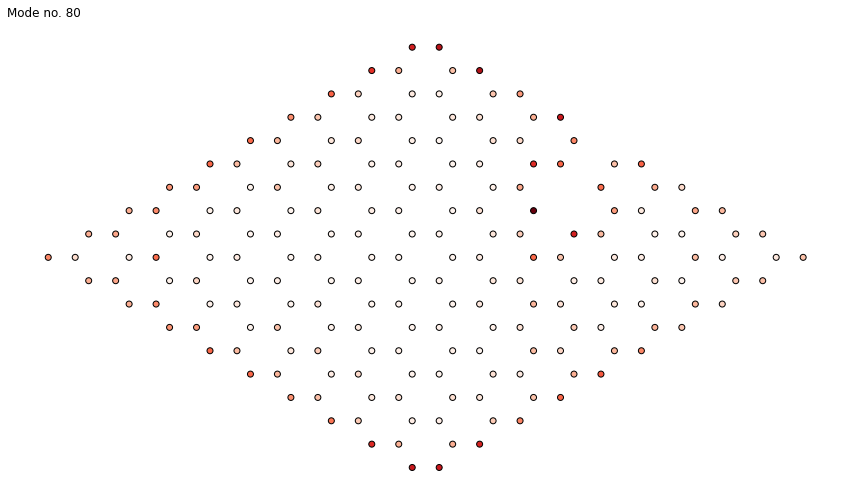

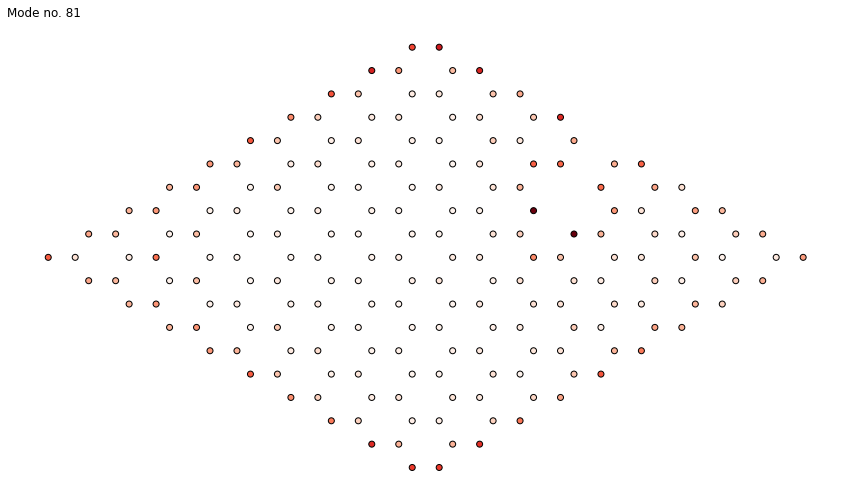

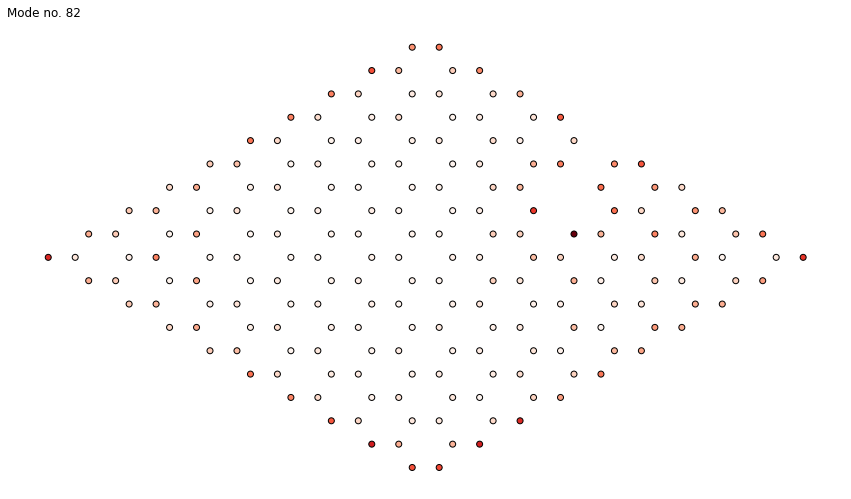

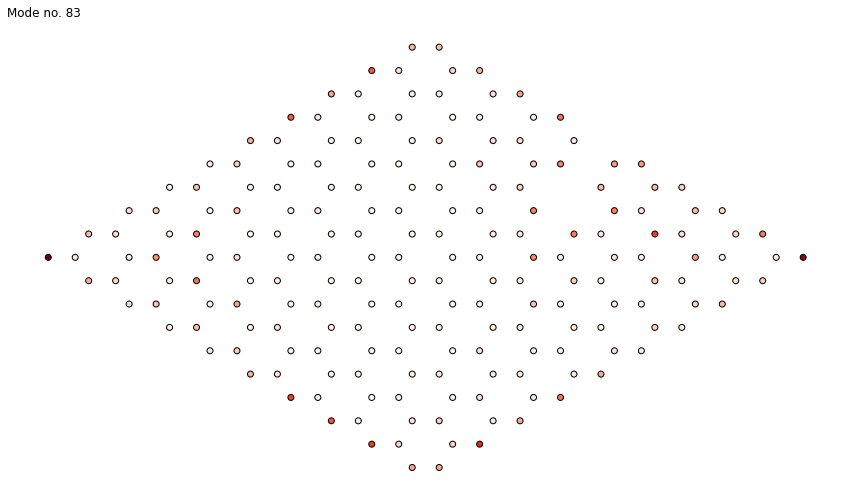

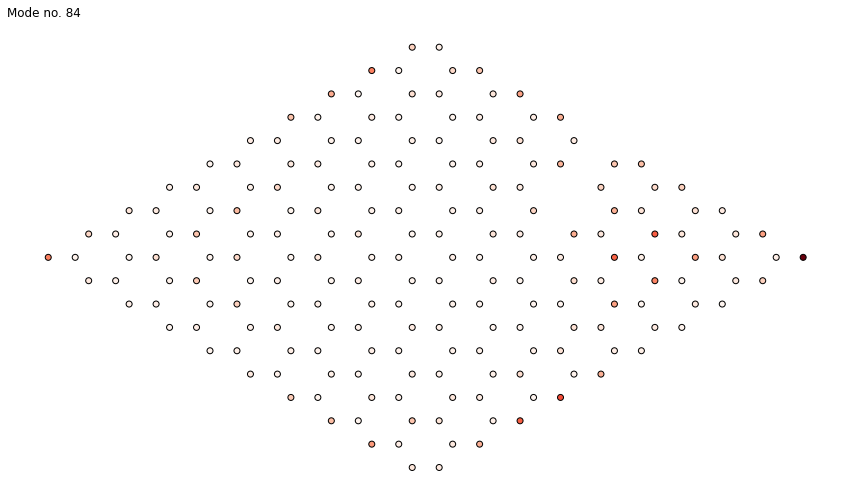

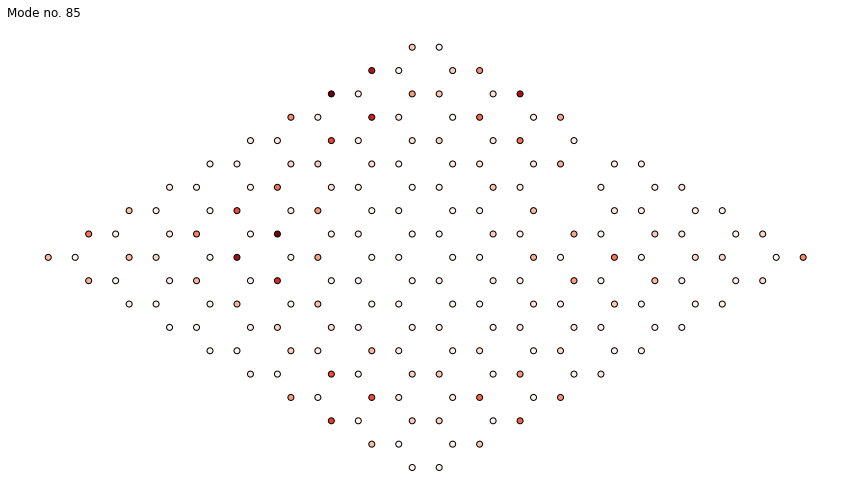

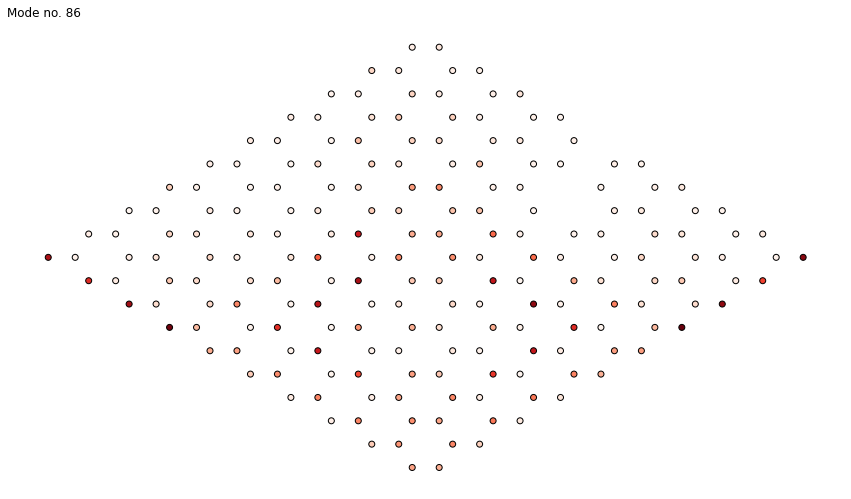

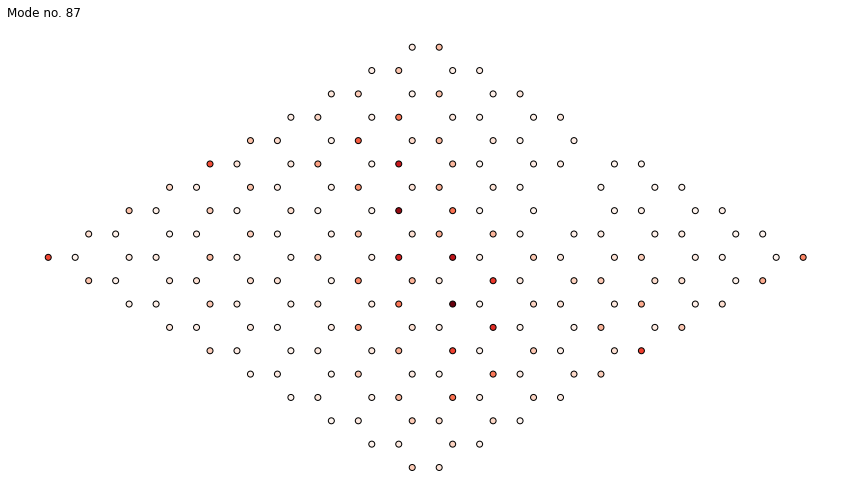

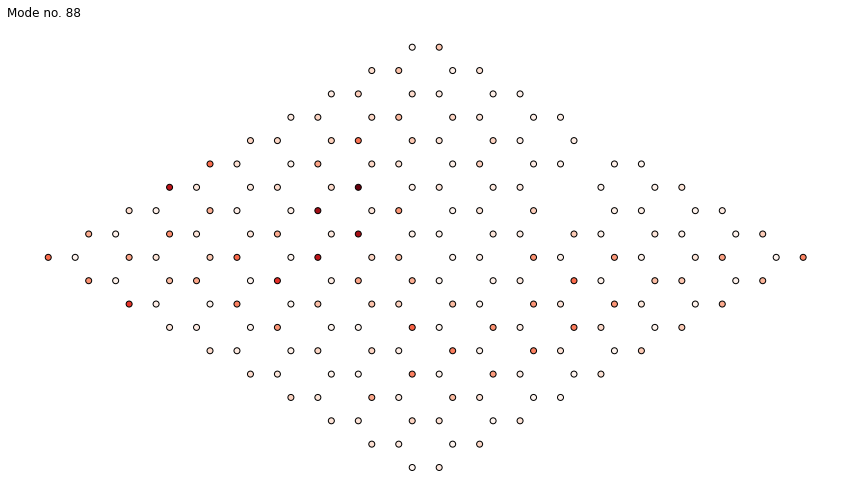

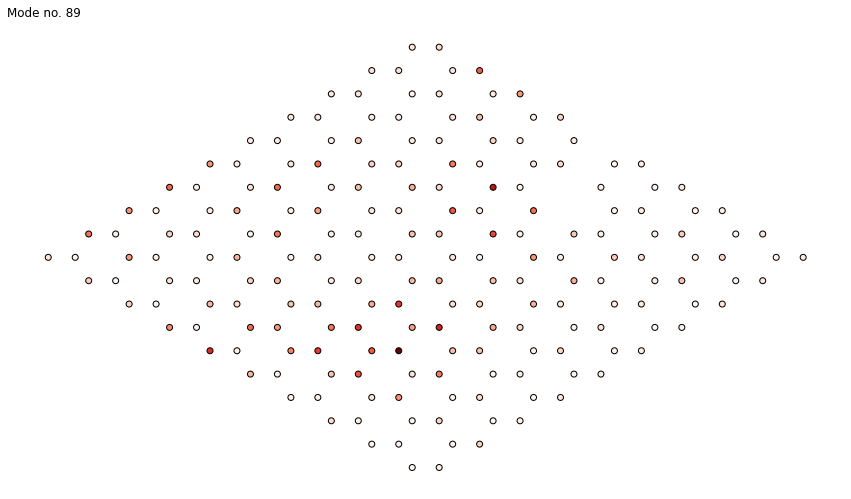

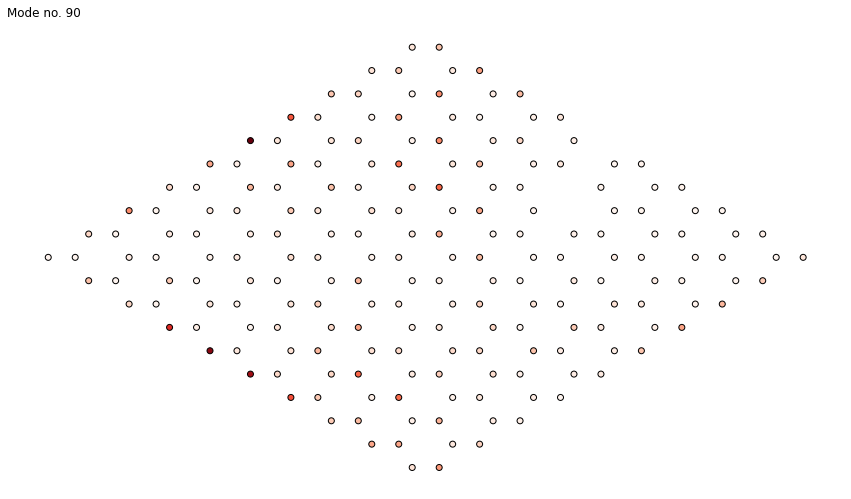

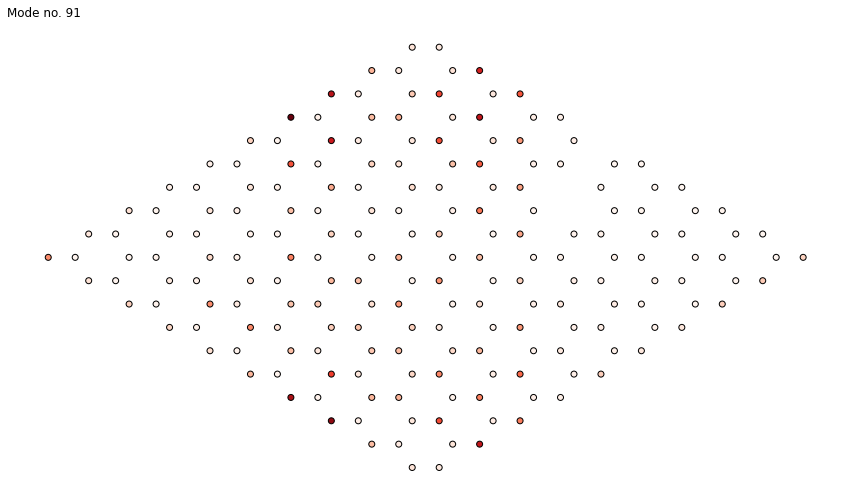

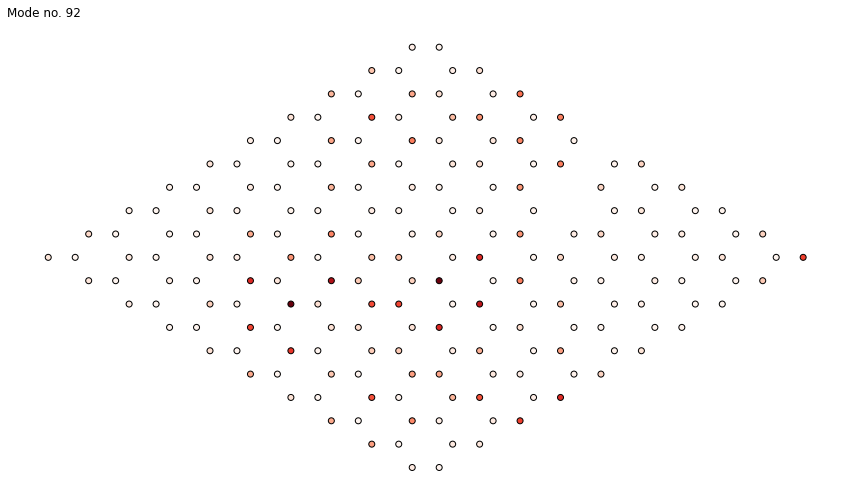

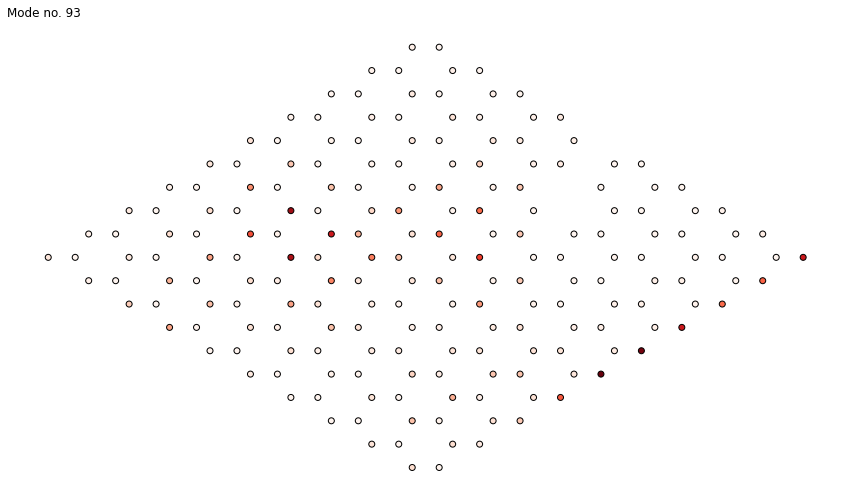

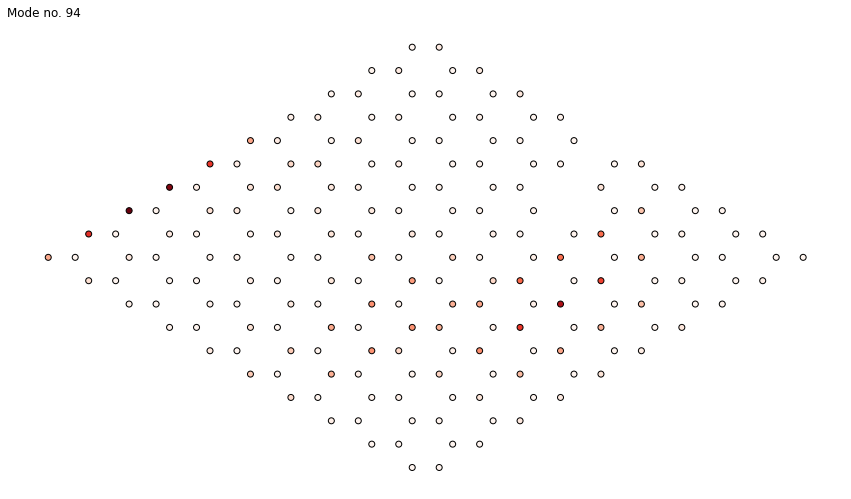

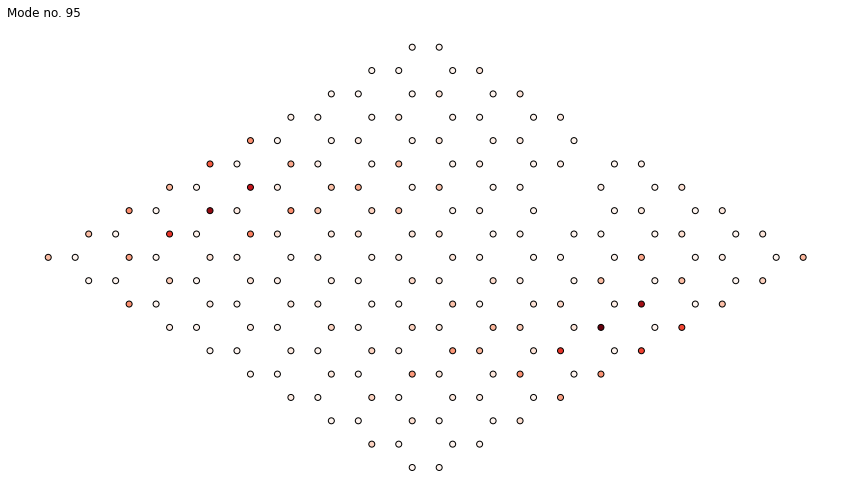

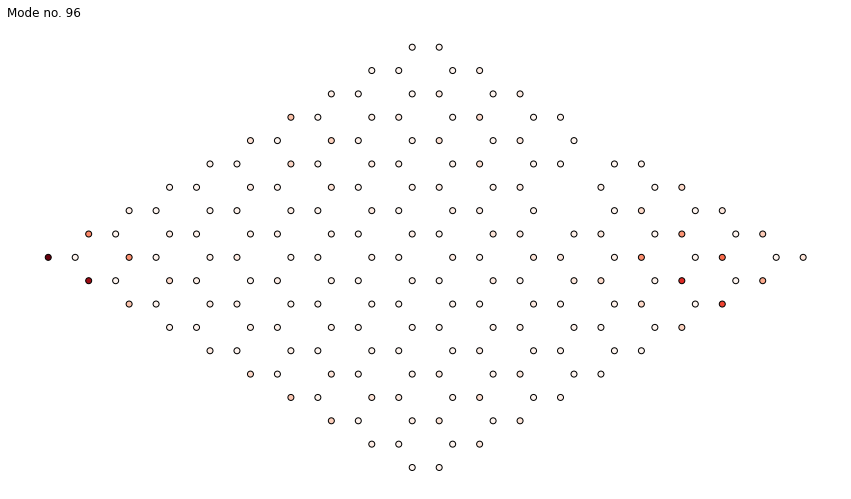

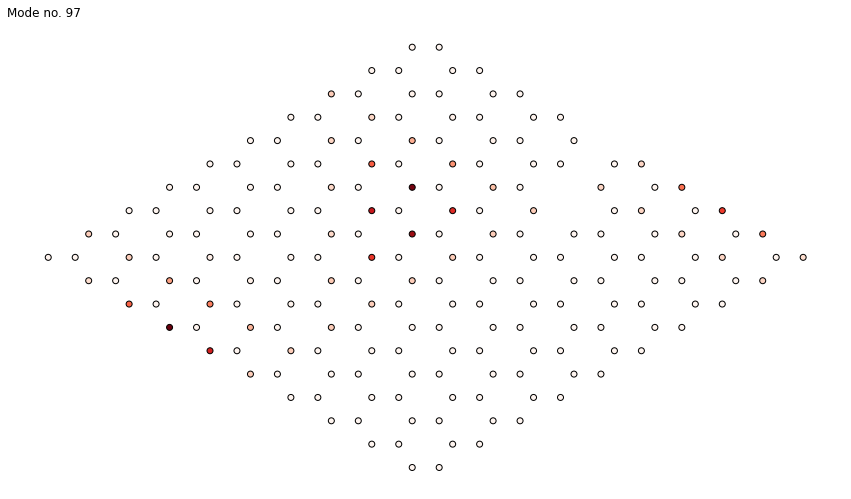

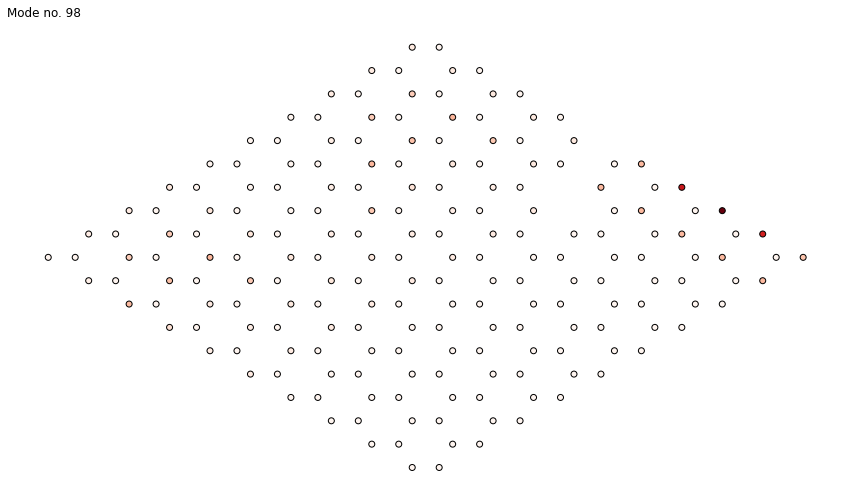

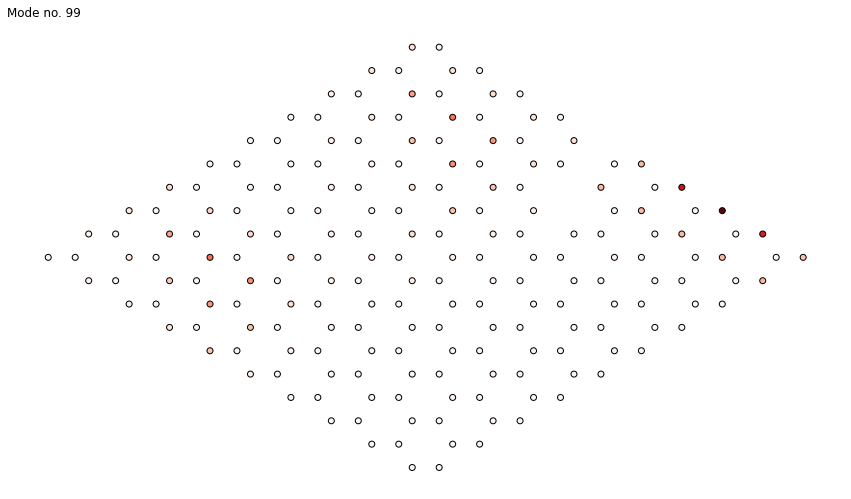

In [19]:

vec_intensities_100 = np.conjugate(beta_vecs_100)*beta_vecs_100

for i in range(70,100):
    plot_coloured_chain(vec_intensities_100[:,i], 3, deformed_lattice,i);

Now we try to turn the on-site term back on and see if any edges remain.

All localised at high twist (10,000,000,000). 1,000,000 shows nothing. 10,000 still too localised. 1000 still localised. 100 shows some interesting modes

True


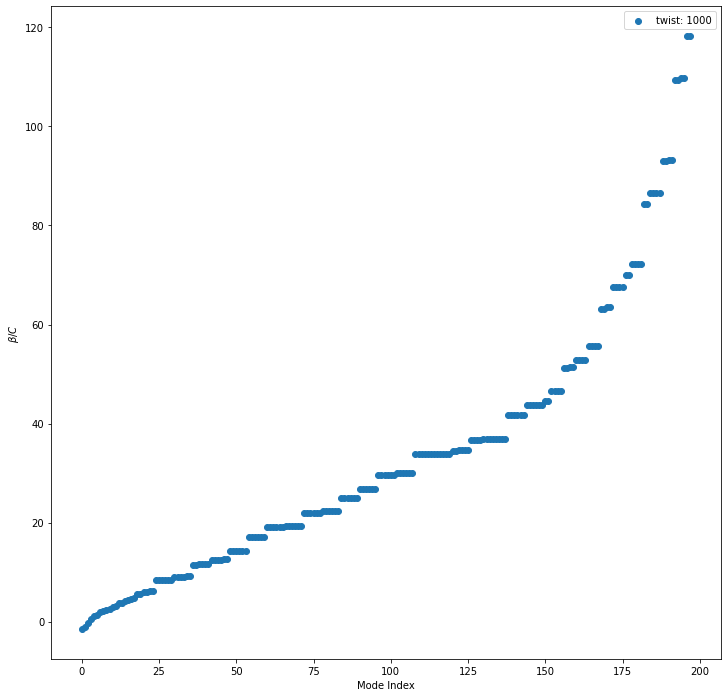

In [92]:
beta_vals_onsite, beta_vecs_onsite = find_eigvalues(deformed_lattice, 4.5, coupling, beta_0, 1000)
plot_betas(beta_vals_onsite, coupling, 'twist: 1000')

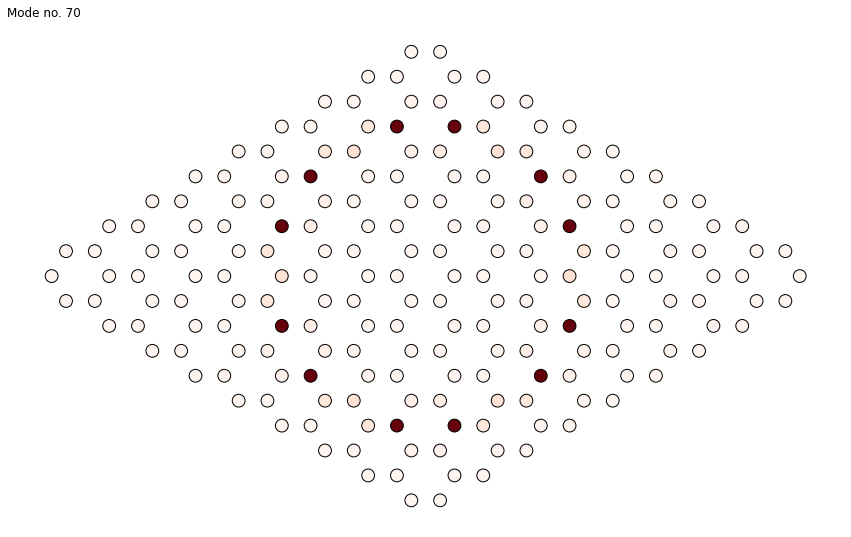

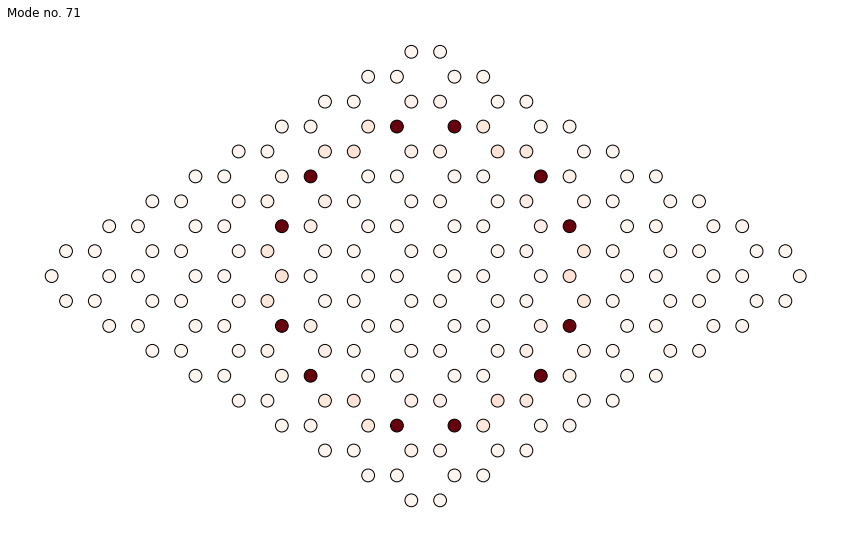

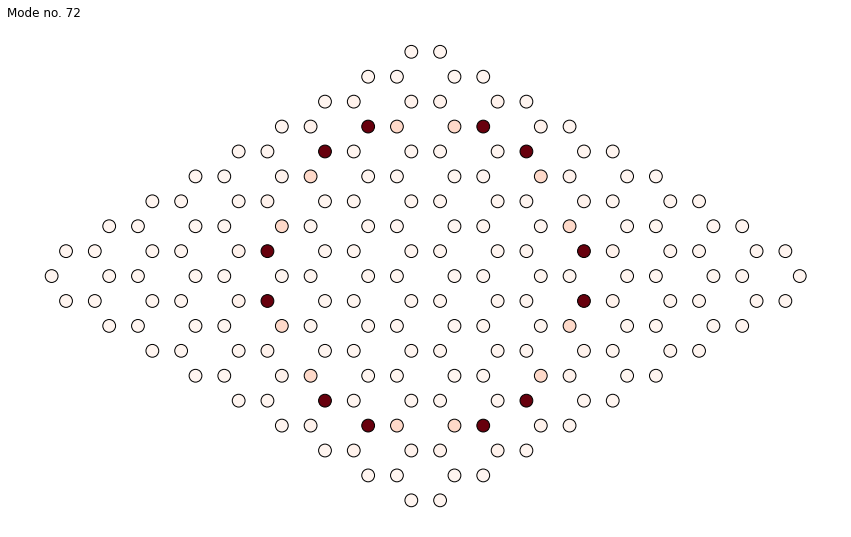

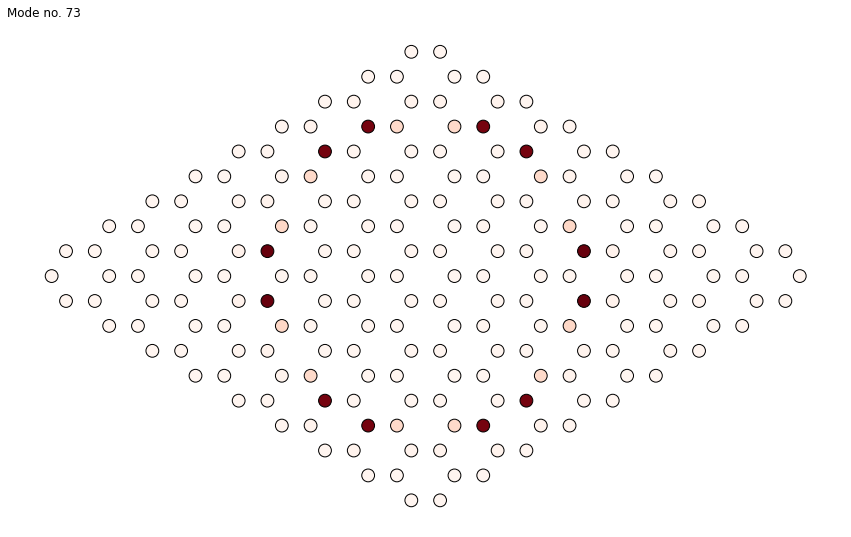

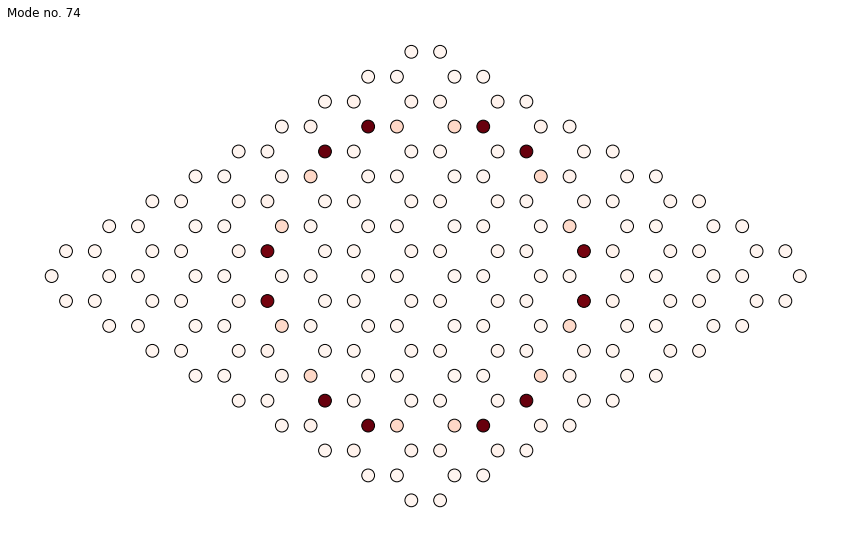

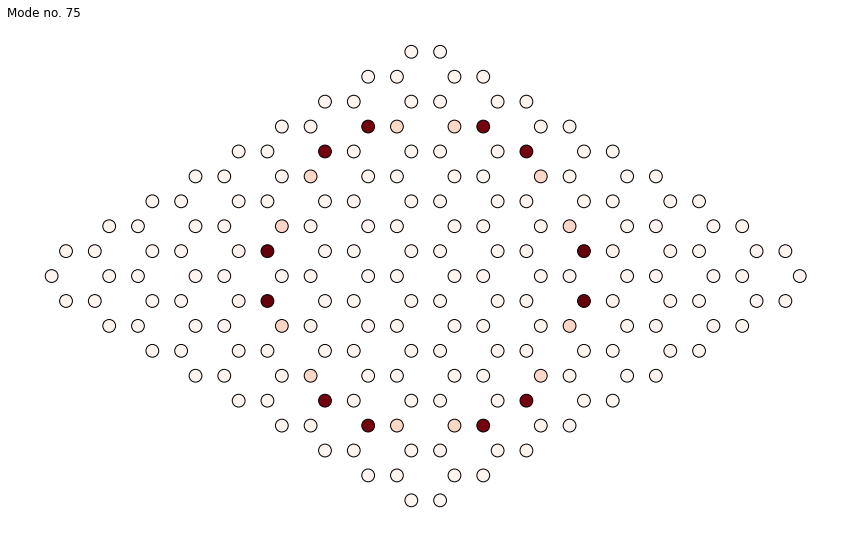

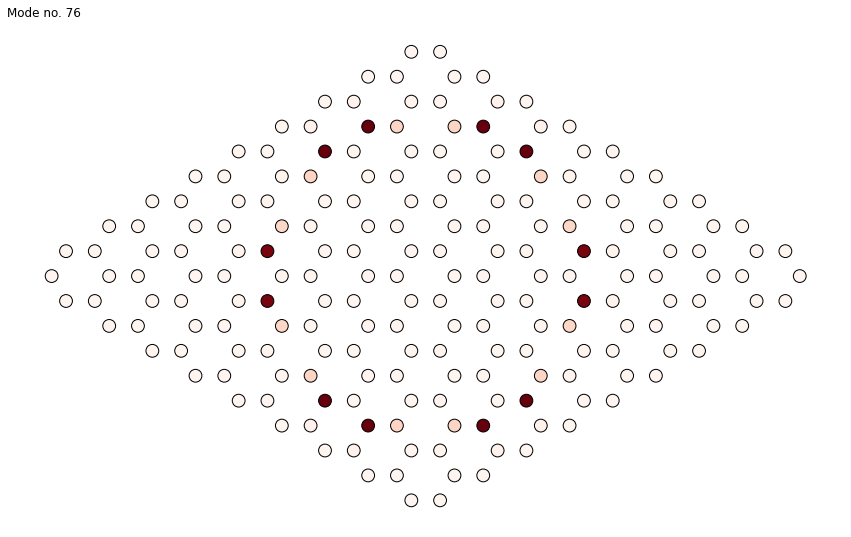

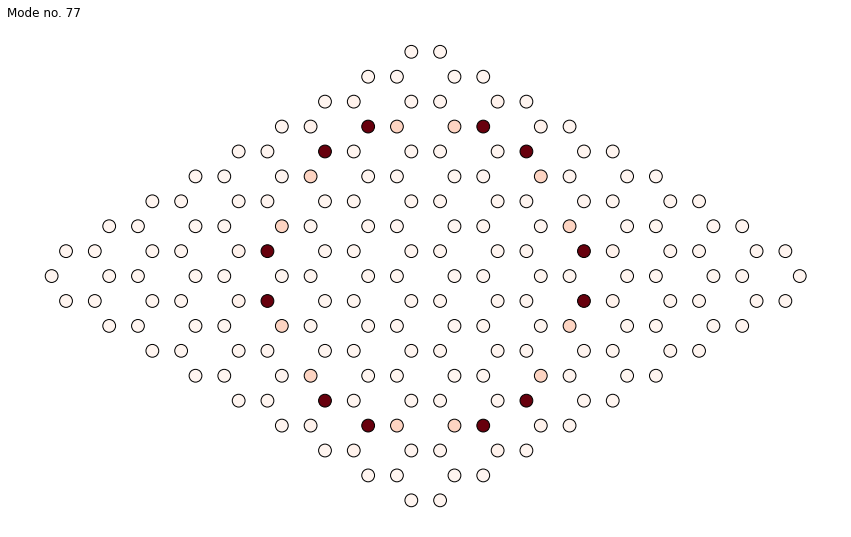

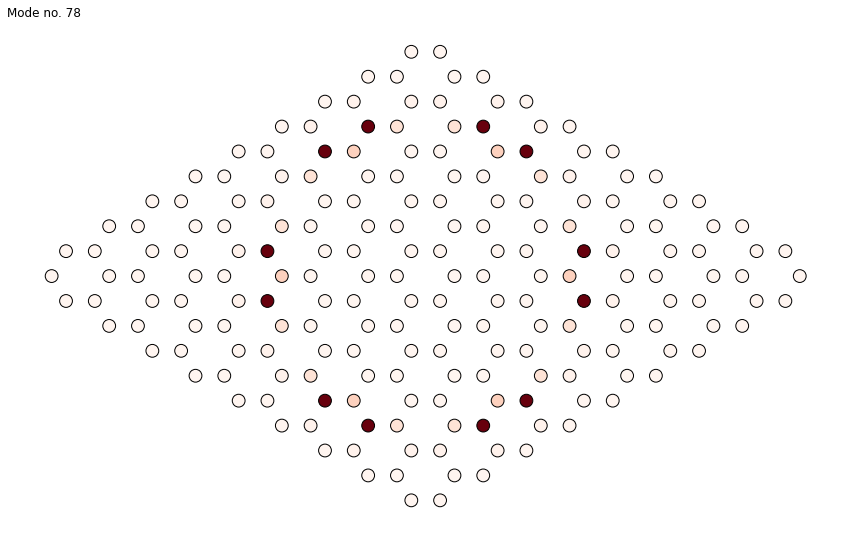

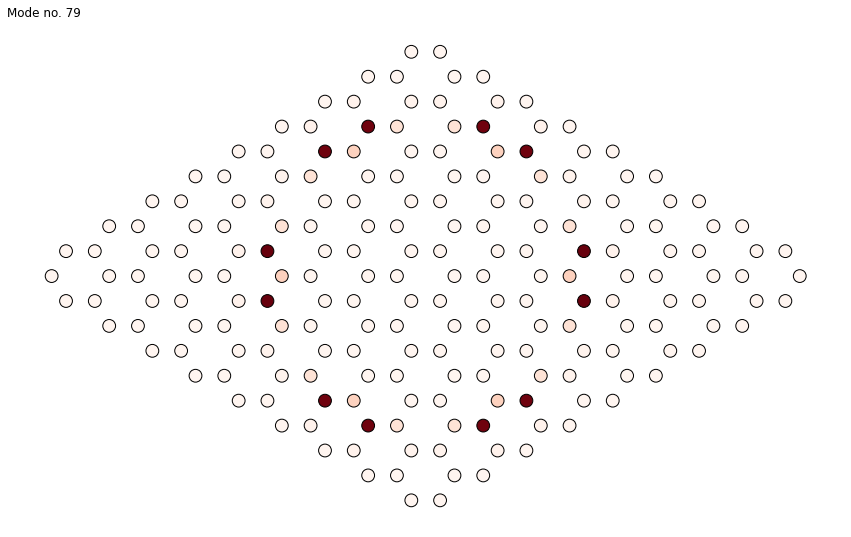

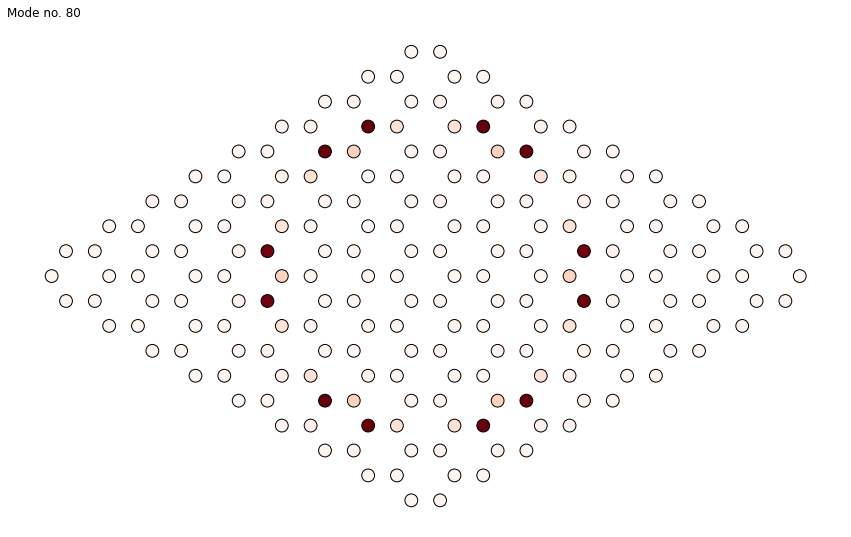

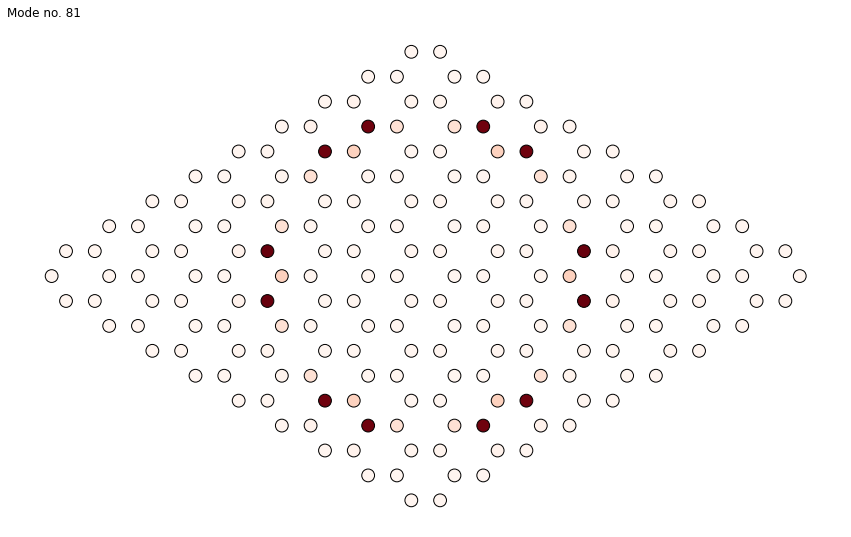

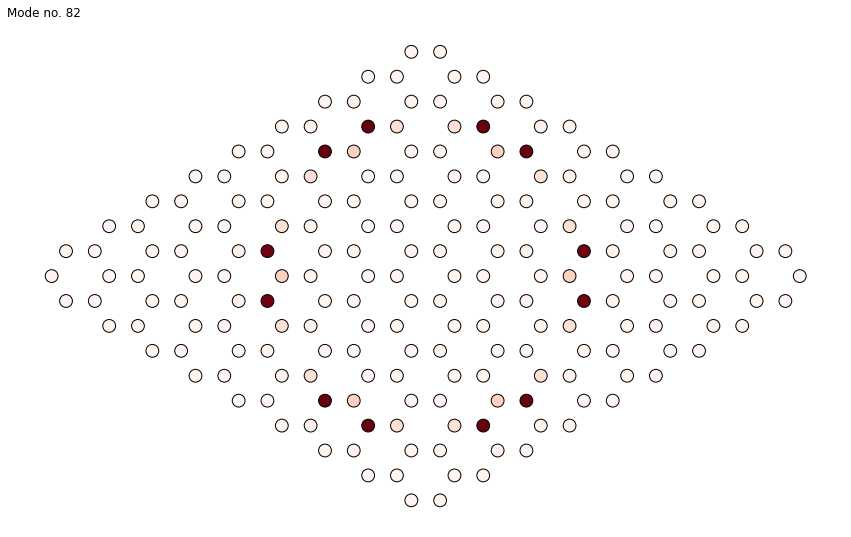

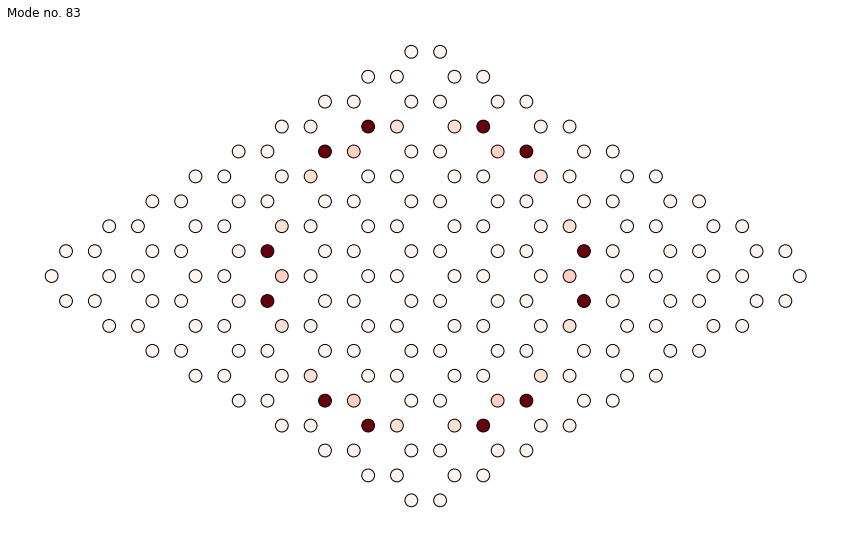

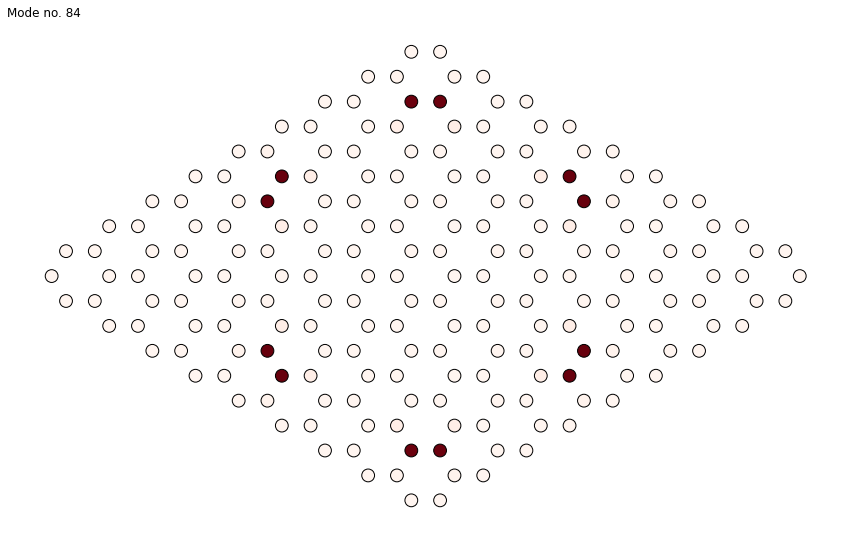

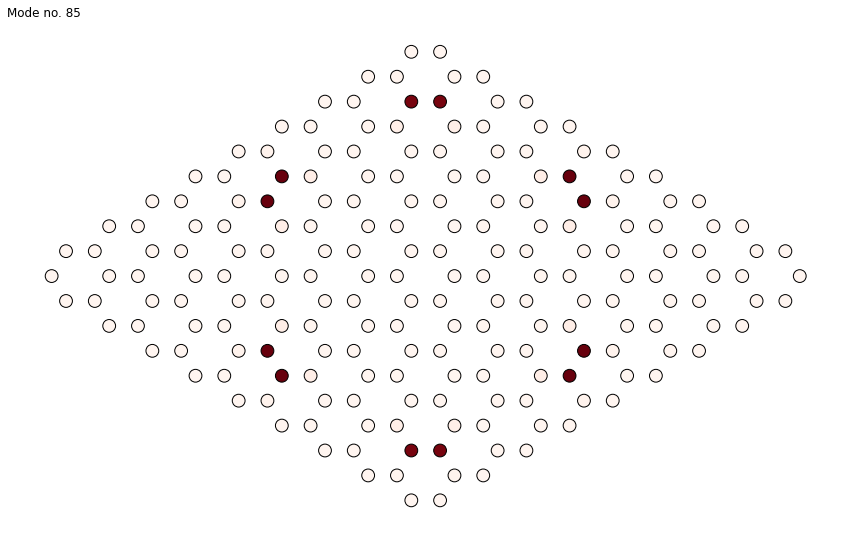

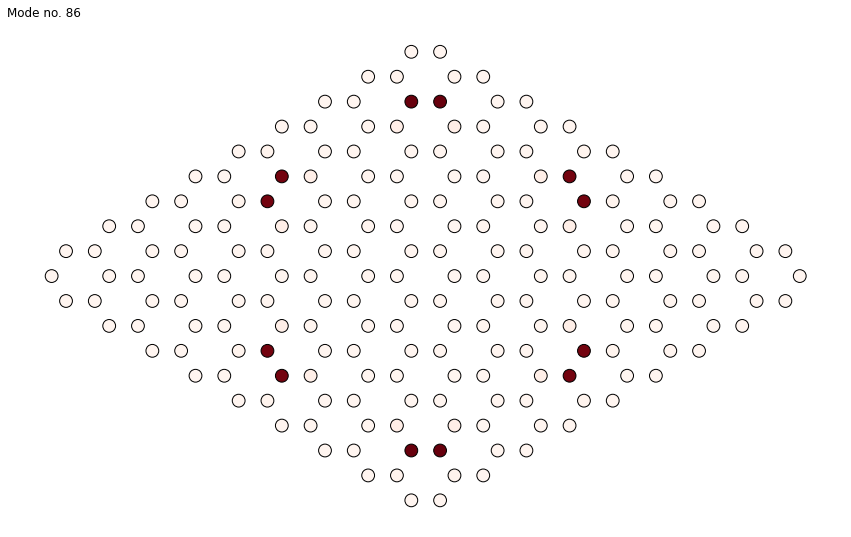

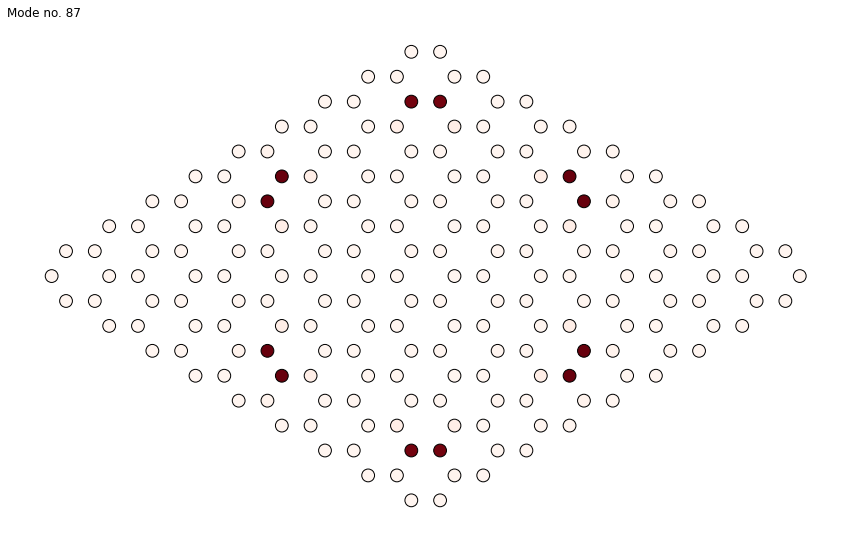

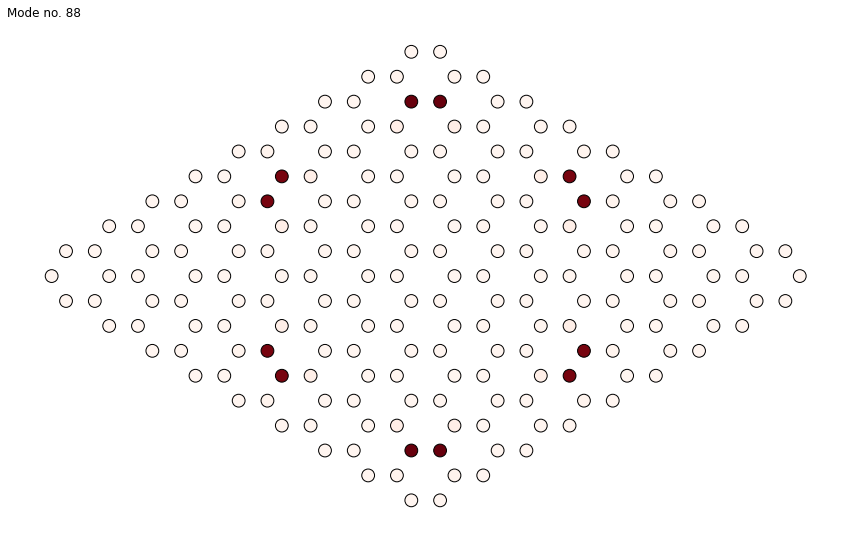

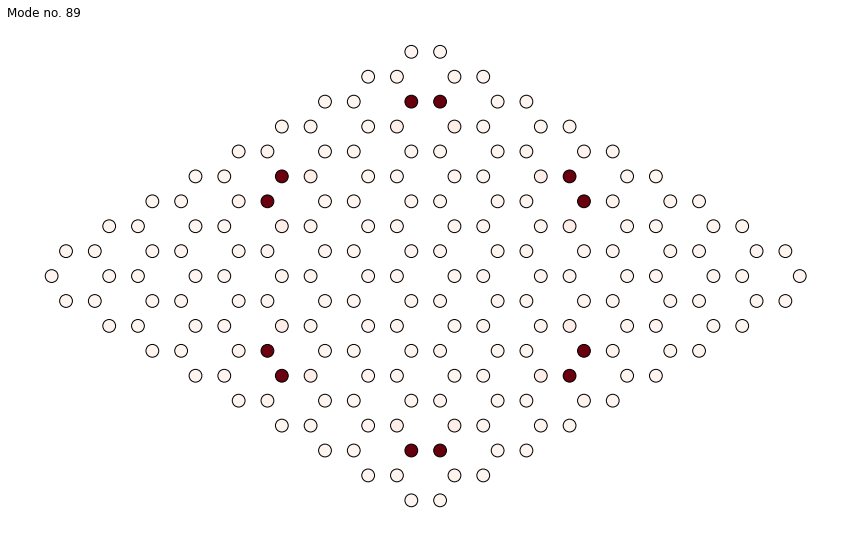

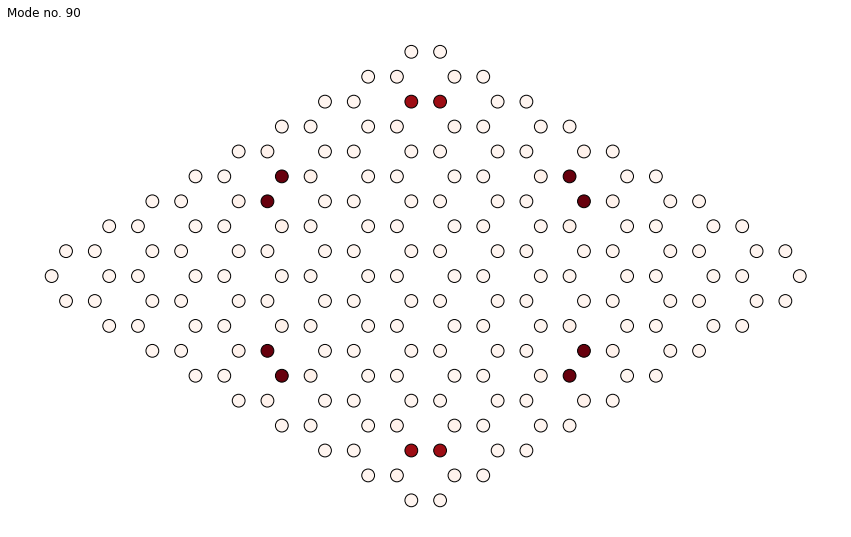

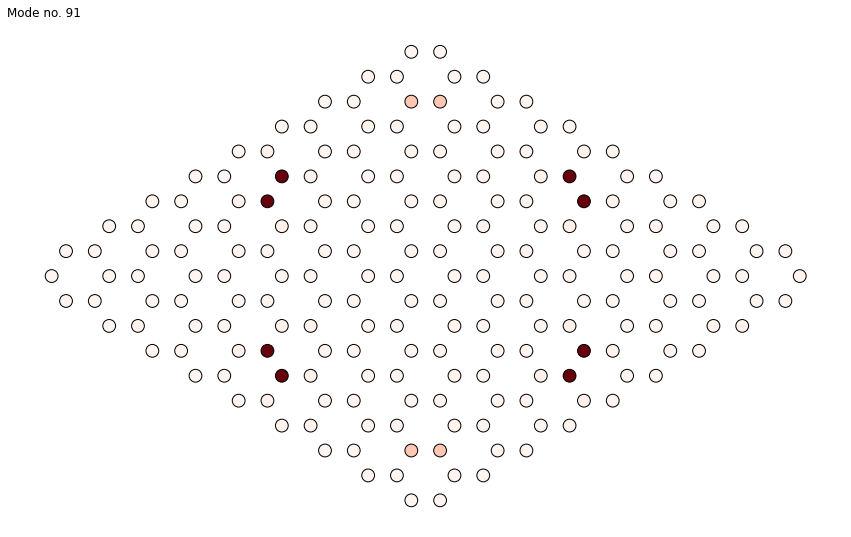

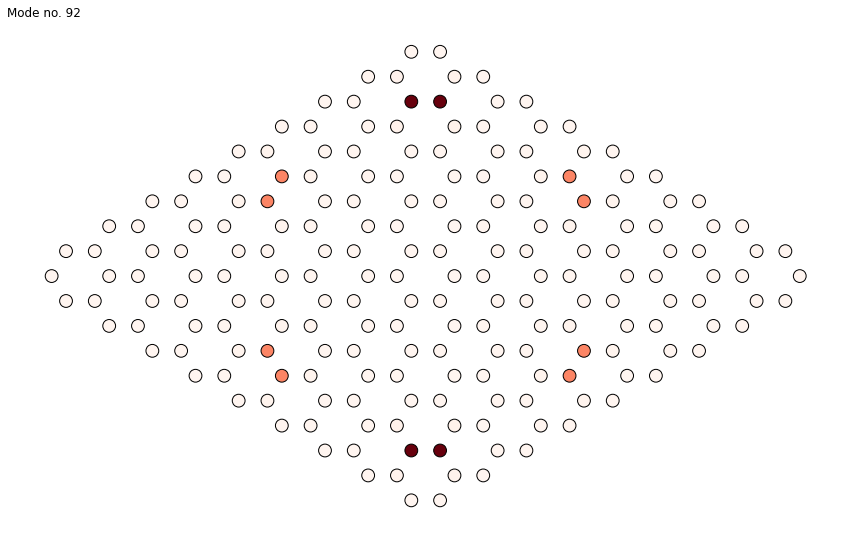

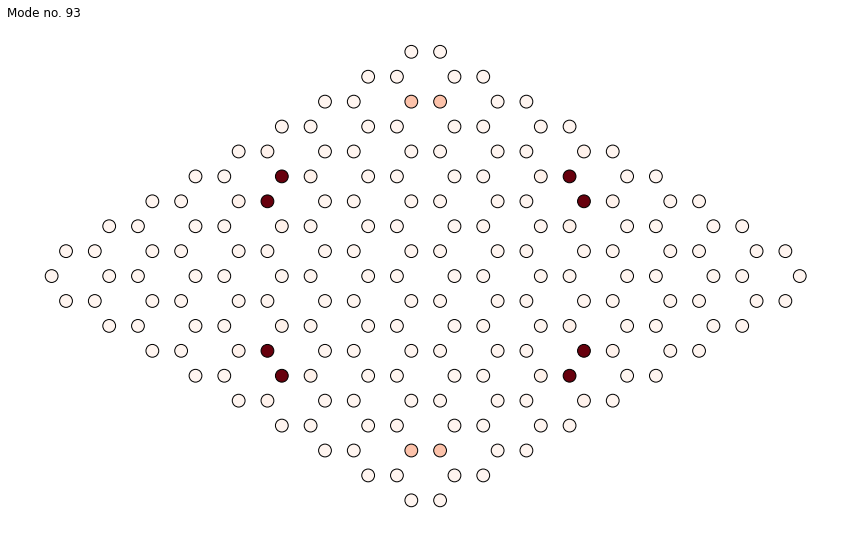

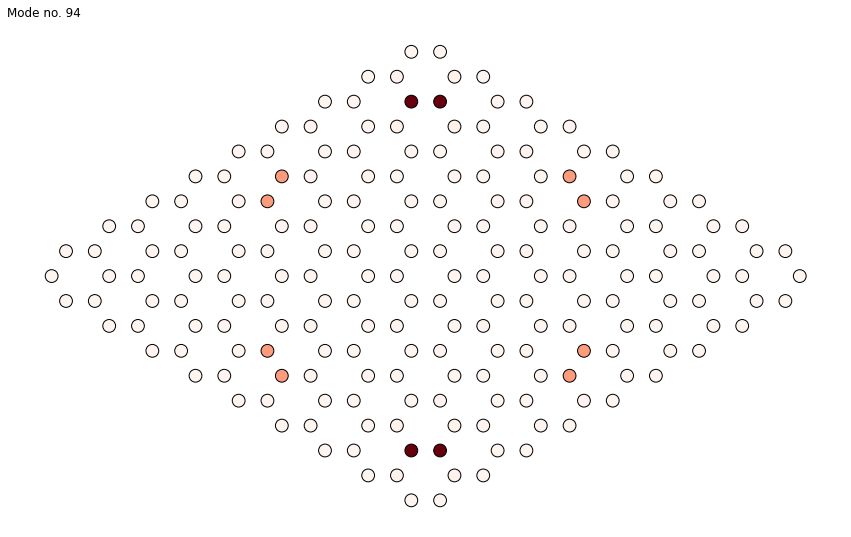

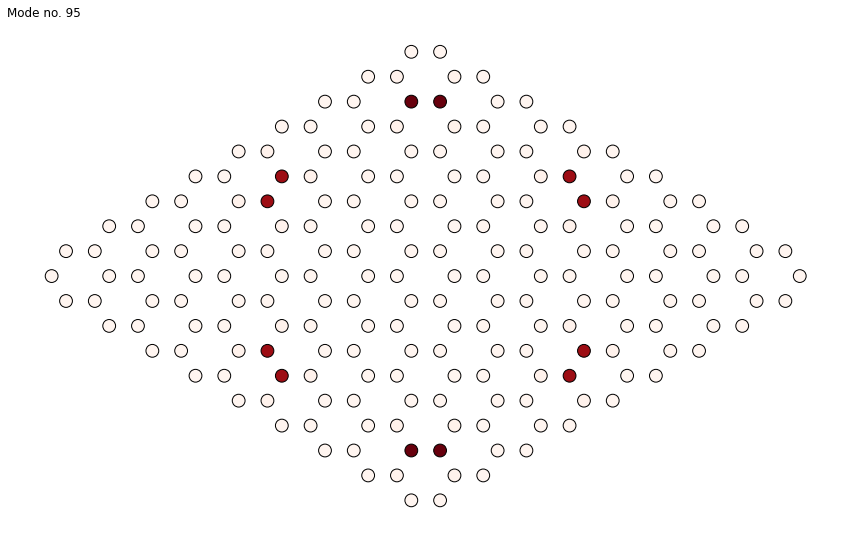

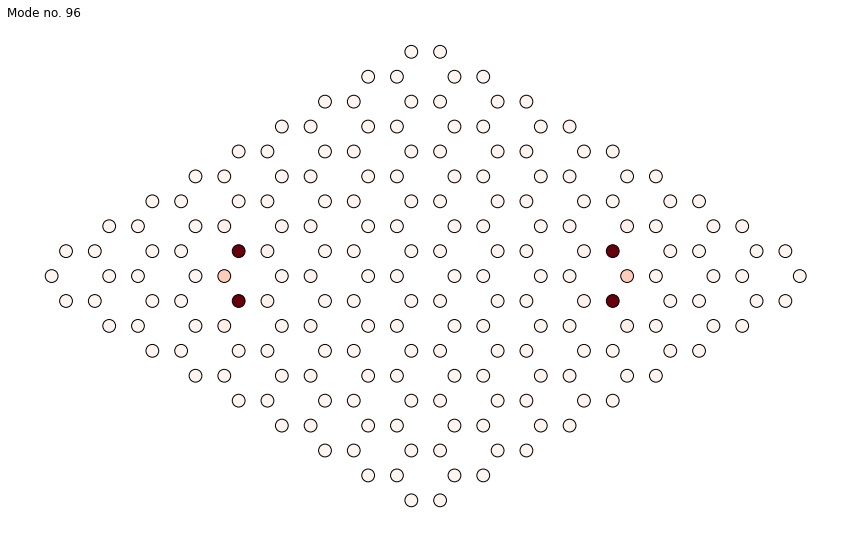

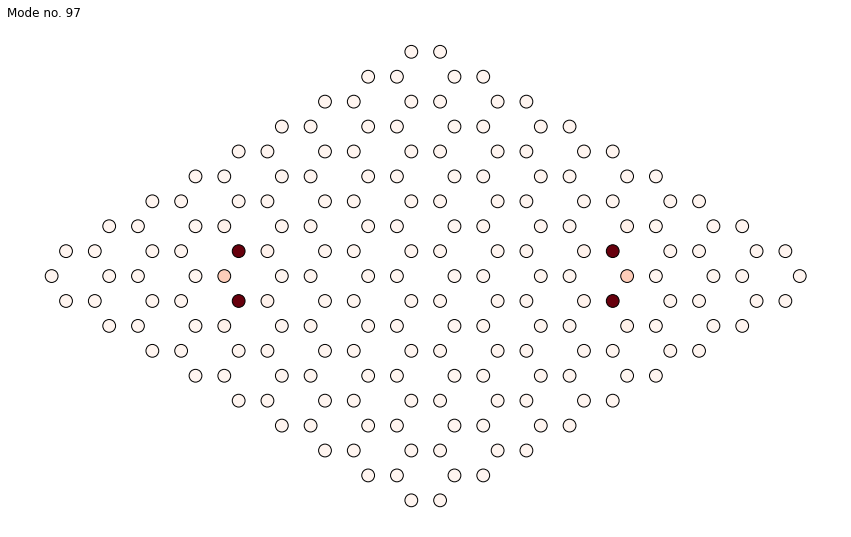

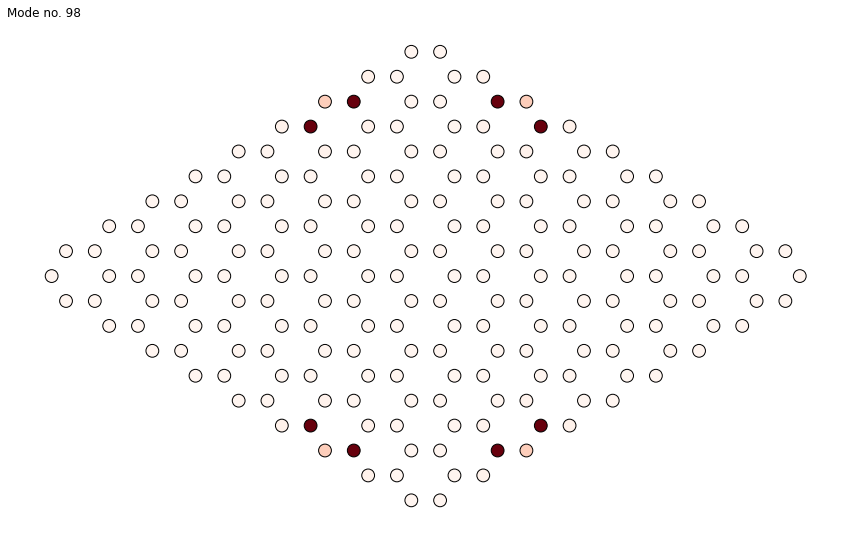

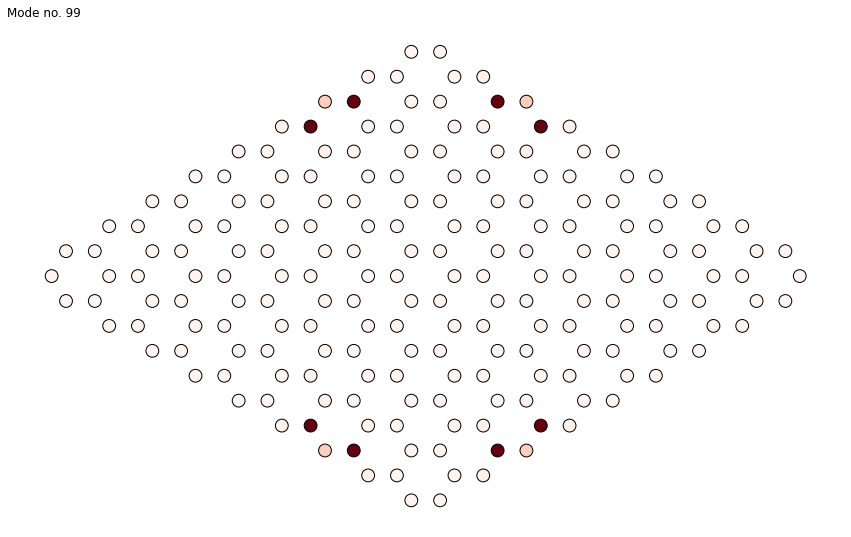

In [93]:

vec_intensities_onsite = np.conjugate(beta_vecs_onsite)*beta_vecs_onsite
edges = np.arange(70,100)#[13,14,15,78,79,80,81,82]
for i in edges:#range(0,20):
    plot_coloured_chain(vec_intensities_onsite[:,i], 3, deformed_lattice,i);

In [ ]:
beta_vals_onsite_low, beta_vecs_onsite_low = find_eigvalues(b_10_list, 4.5, 3*coupling, beta_0, 50)
plot_betas(beta_vals_onsite_low, 3*coupling)

In [ ]:

vec_intensities_onsite_low = np.conjugate(beta_vecs_onsite_low)*beta_vecs_onsite_low

for i in range(3000,3050):
    plot_coloured_chain(vec_intensities_onsite_low[:,i], 3, b_10_list,i);

In [162]:
vec_pot_list = []

for n in range(100):
    mid_point = (b_10_list[0,:] + b_10_list[n,:])/2
    a_dist = (b_10_list[0,:] - b_10_list[n,:])*1.0e-6
    term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, 1000, beta_0)
    vec_pot_list.append(np.exp(1.0j *np.dot(term, a_dist)))

In [163]:
plt.plot(np.arange(len(vec_pot_list)), vec_pot_list);
# plt.axhline(1.0, color='black');
# plt.axvline(272,color='red');

c:\Users\nr421\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [ ]:
print(vec_pot_list[265:275])

In [ ]:
vec_pot_list_2 = []

for m in range(59):
    mid_point = (b_10_list[0,:] + b_10_list[(m+1)*60,:])/2
    a_dist = (b_10_list[0,:] - b_10_list[(m+1)*60,:])*1.0e-6
    term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, 20, beta_0)
    vec_pot_list_2.append(np.exp(1.0j *np.dot(term, a_dist)))

In [ ]:
plt.plot(np.arange(len(vec_pot_list_2)), vec_pot_list_2);
# plt.axhline(1.0, color='black');
# plt.axvline(272,color='red');

Selecting only a hexagon around the origin to look at overall gamma change 

In [172]:
pos = []

fig_hex = plt.figure(figsize=(9,6))
ax_hex = fig_hex.add_subplot(111)

ax_hex.scatter(b_10_list[:,0], b_10_list[:,1], cmap='Reds')
ax_hex.xaxis.set_major_locator(MultipleLocator(10))
ax_hex.xaxis.set_minor_locator(MultipleLocator(5))
ax_hex.yaxis.set_major_locator(MultipleLocator(10))
ax_hex.yaxis.set_minor_locator(MultipleLocator(5))
#ax1.xaxis.set_major_formatter({x:.0f})
plt.grid(which='both')

fig_hex.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [176]:


pos = np.array(pos)
points_to_keep = np.where(cdist(b_10_list, pos, 'euclidean')>2, False, True )
index_to_keep = np.any(points_to_keep, axis=1)
selected_hexagon = b_10_list[index_to_keep]
# [print(type(i)) for i in pos]
col_list = ['red', 'green', 'black', 'blue', 'yellow', 'brown']
for i in range(6):
    plt.scatter(selected_hexagon[i,0], selected_hexagon[i,1], color=col_list[i]);

In [184]:
alist = []
phase_list = []

for coord in enumerate(selected_hexagon):
    alist.append(vec_potential(coord[0]*1.0e-6, coord[1]*1.0e-6, 20, beta_0))

r1_2 = selected_hexagon[2] - selected_hexagon[4] # yellow to black
r2_3 = selected_hexagon[5] - selected_hexagon[2] # black to brown
r3_4 = selected_hexagon[1] - selected_hexagon[5] # brown to green
r4_5 = selected_hexagon[3] - selected_hexagon[1] # green to blue
r5_6 = selected_hexagon[0] - selected_hexagon[3] # blue to red
r6_1 = selected_hexagon[4] - selected_hexagon[0] # red to yellow 

r_list = [r6_1, r4_5, r2_3, r5_6, r1_2, r3_4]
phase_list = np.array([1,-1,1,-1,1,-1])

for n in range(len(r_list)):
    sum_list = phase_list[n]*np.dot(r_list[n]*1.0e-6,alist[n])

print(sum(sum_list))

0.012944509416397219


That kind of looks like nonsense. I will do the square case and verify it all works 